# Quantum data learning for quantum simulations in high-energy physics


## The variational quantum eigensolver

Variational quantum algorithms are promising candidate hybrid-algorithms for observing quantum computation utility on noisy near-term devices. Variational algorithms are characterized by the use of a classical optimization algorithm to iteratively update a parameterized trial solution, or "ansatz". 

Chief among these methods is the variational quantum eigensolver (VQE) that aims to solve for the ground state of a given Hamiltonian represented as a linear combination of Pauli terms, with an ansatz circuit where the number of parameters to optimize over is polynomial in the number of qubits.[1]

Given that the size of the full solution vector is exponential in the number of qubits, successful minimization using VQE requires, in general, additional problem-specific information to define the structure of the ansatz circuit.

Executing a VQE algorithm requires the following components:

1. Hamiltonian and ansatz (problem specification)
2. Qiskit Runtime estimator
3. Classical optimizer

Although the Hamiltonian and ansatz require domain-specific knowledge to construct, these details are immaterial to the Runtime, and we can execute a wide class of VQE problems in the same manner.


## Setup

Here we import the tools needed for a VQE experiment.


In [1]:
# General imports
import numpy as np

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit import QuantumCircuit
from qiskit.circuit.library import EvolvedOperatorAnsatz
from qiskit.quantum_info import SparsePauliOp

# Qiskit Primitive imports
from qiskit.primitives import BaseEstimatorV2, BackendEstimatorV2 as Estimator
from qiskit.providers.fake_provider import GenericBackendV2

from tqdm import tqdm

from lattice_schwinger_model import LatticeSchwingerModel

## Step 1: Create lattice Schwinger model Hamiltonian

Although the problem instance in question for the VQE algorithm can come from a variety of domains, the form for execution through Qiskit Runtime is the same. Qiskit provides a convenience class for expressing Hamiltonians in Pauli form, and a collection of widely used ansatz circuits in the [`qiskit.circuit.library`](https://docs.quantum-computing.ibm.com/api/qiskit/circuit_library).

When mapped to a spin model, the Schwinger model can be described by a Hamiltonian,

$$
H_{\text{spin}} = J \sum_{n=0}^{N-2} \left(\sum_{k=0}^n\frac{Z_k + (-1)^k}{2} + \frac{\vartheta}{2\pi}\right)^2 + \frac{w}{2}\sum_{n=0}^{N-2}\left(X_n X_{n+1} + Y_n Y_{n+1}\right) + \frac{m}{2}\sum_{n=0}^{N-1}(-1)^n Z_n,
$$

where $J$ is the coupling constant, $\vartheta$ is related to the original photonic kinetic term, $\omega$ is related to the lattice spacing, and $m$ is the electron mass.[2]

In [2]:
mass: float = 0.1
coupling: float = 1.0
num_sites: int = 2*2
spacing: float = 1.0
model = LatticeSchwingerModel(mass, coupling, num_sites, spacing)
hamiltonian: list[SparsePauliOp] = model.get_hamiltonian()
num_qubits = hamiltonian[0].num_qubits

Our choice of ansatz is the `EvolvedOperatorAnsatz`. Please see the [Qiskit documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.EvolvedOperatorAnsatz) for more information.


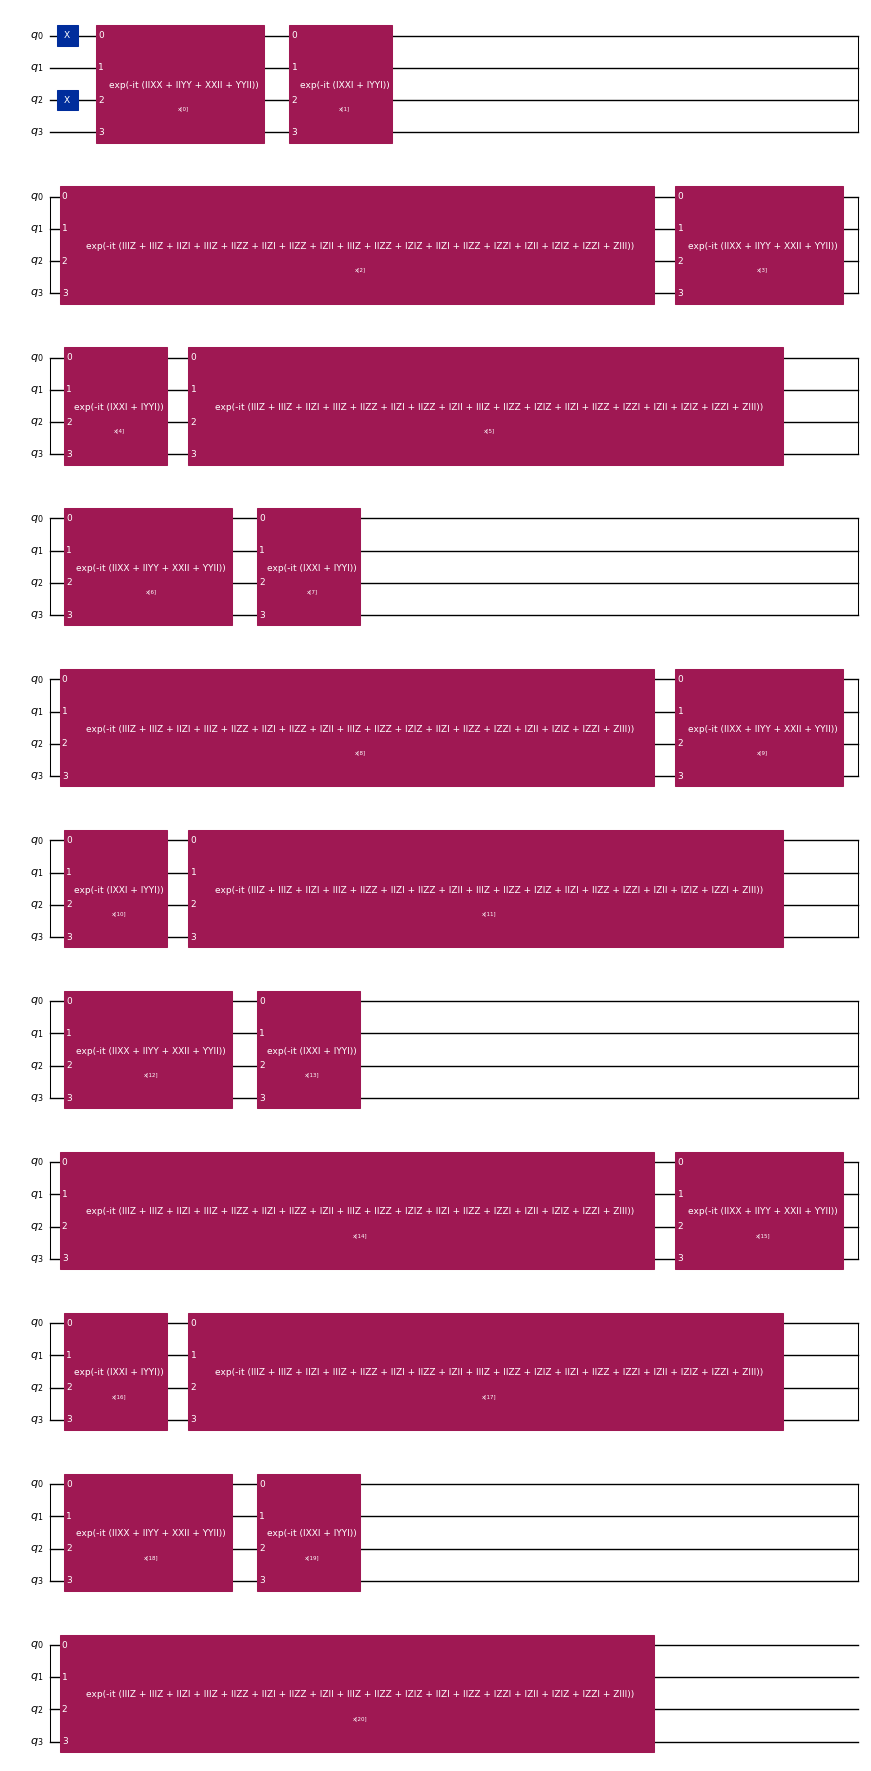

In [3]:
initial_circuit = QuantumCircuit(num_qubits)
for q in range(0, num_qubits, 2):
    initial_circuit.x(q)

ansatz = EvolvedOperatorAnsatz(
    operators=hamiltonian, 
    reps=7, 
    evolution=None, 
    parameter_prefix='x',
    initial_state=initial_circuit
)

ansatz.decompose().draw("mpl", style="iqp", scale=0.5)

From the previous figure we see that our ansatz circuit is defined by a vector of parameters, $\theta_{i}$, with the total number given by:


In [4]:
num_params: int = ansatz.num_parameters
num_params

21

## Step 2: Optimize problem for quantum execution


To reduce the total job execution time, Qiskit primitives only accept circuits (ansatz) and observables (Hamiltonian) that conform to the instructions and connectivity supported by the target system (referred to as instruction set architecture (ISA) circuits and observables).


### ISA circuit


Schedule a series of [`qiskit.transpiler`](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler) passes to optimize the circuit for a selected backend and make it compatible with the backend's ISA. This can be easily done with a preset pass manager from `qiskit.transpiler` and its `optimization_level` parameter.

The lowest optimization level does the minimum needed to get the circuit running on the device; it maps the circuit qubits to the device qubits and adds swap gates to allow all two-qubit operations. The highest optimization level is much smarter and uses lots of tricks to reduce the overall gate count. Since multi-qubit gates have high error rates and qubits decohere over time, the shorter circuits should give better results.


In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = GenericBackendV2(num_sites)
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

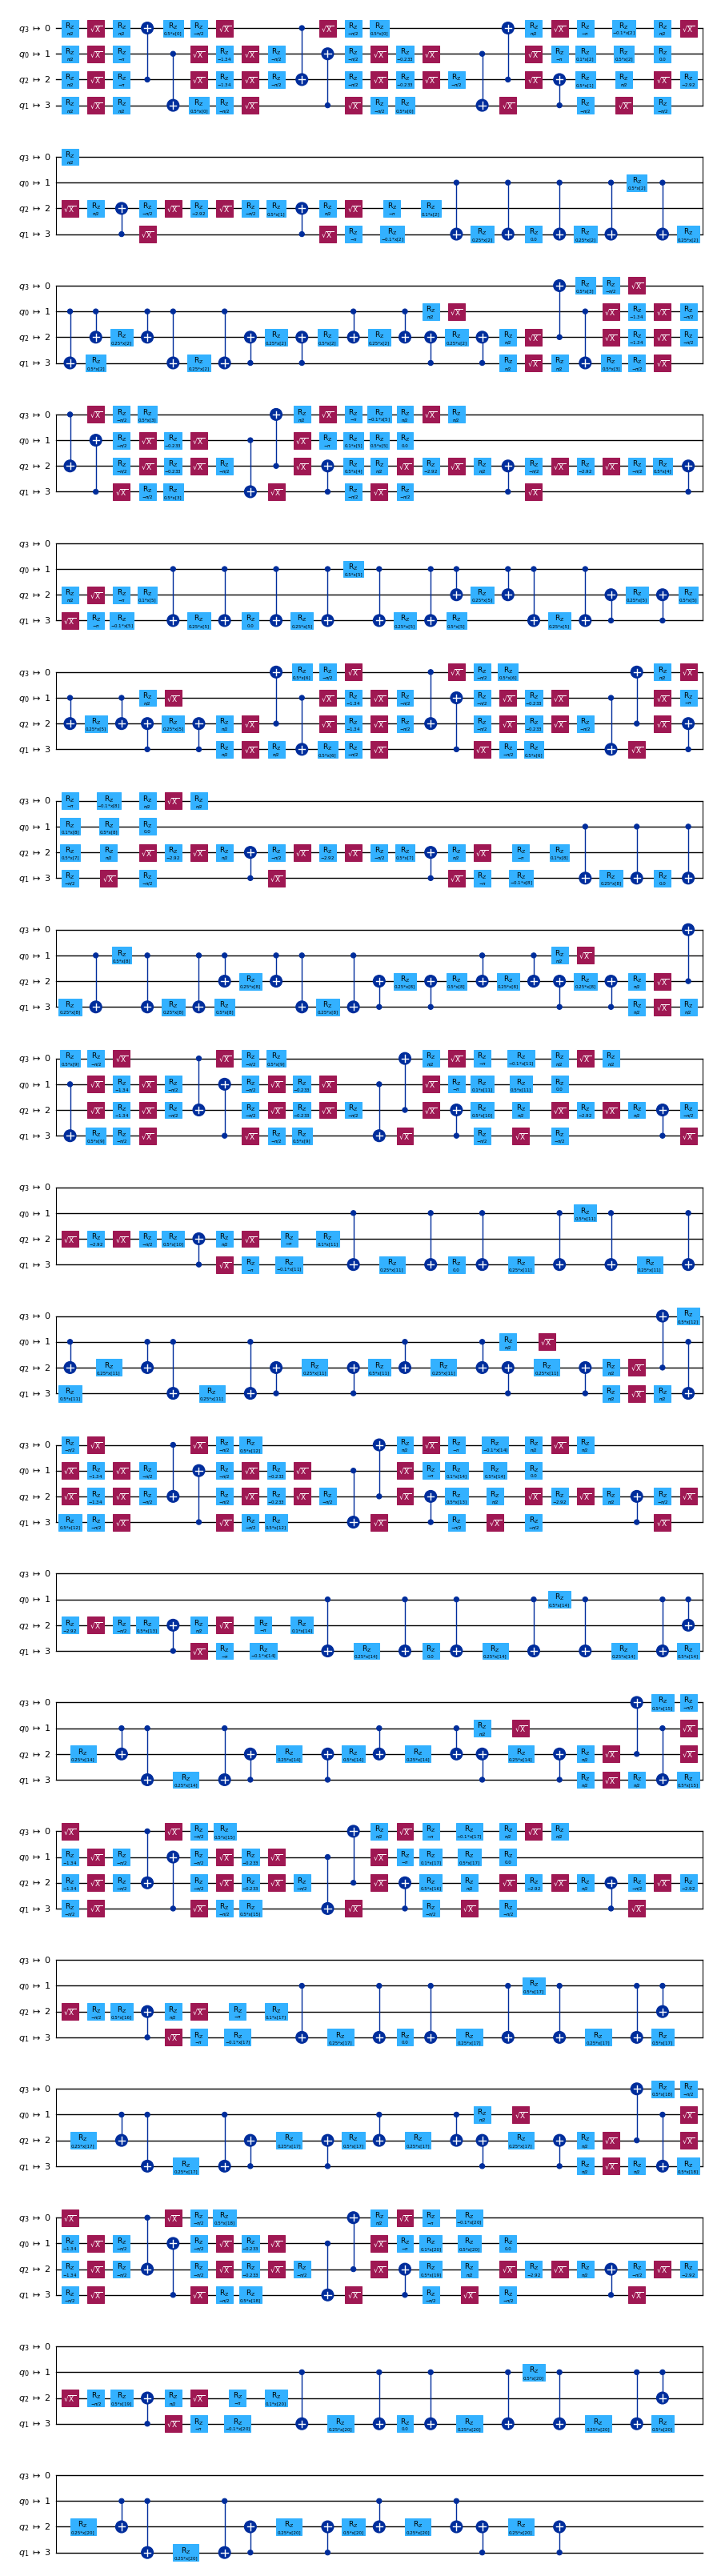

In [6]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp", scale=0.5)

### ISA observable


Transform the Hamiltonian to make it backend-compatible before running jobs with [`Runtime Estimator V2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2#run). Perform the transformation by using the `apply_layout` method of `SparsePauliOp` object.


In [7]:
hamiltonian_isa = [h.apply_layout(layout=ansatz_isa.layout) for h in hamiltonian]

## Step 3: Execute using Qiskit Primitives

Like many classical optimization problems, the solution to a VQE problem can be formulated as minimization of a scalar cost function.  By definition, VQE looks to find the ground state solution to a Hamiltonian by optimizing the ansatz circuit parameters to minimize the expectation value (energy) of the Hamiltonian.  With the Qiskit Runtime [`Estimator`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy, the cost function for a VQE instance is quite simple.

Note that the `run()` method of [Qiskit Runtime `EstimatorV2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2)  takes an iterable of `primitive unified blocs (PUBs)`. Each PUB is an iterable in the format `(circuit, observables, parameter_values: Optional, precision: Optional)`.


In [8]:
def cost_func(
    params: np.ndarray,
    ansatz: QuantumCircuit,
    hamiltonian: SparsePauliOp,
    estimator: BaseEstimatorV2,
    history: dict,
    verbose: bool = True,
) -> float:
    """Return estimate of energy from estimator

    Parameters:
        params: Array of ansatz parameters.
        ansatz: Parameterized ansatz circuit.
        hamiltonian: Operator representation of Hamiltonian.
        estimator: Estimator primitive instance.
        history: Dictionary for storing intermediate results.

    Returns:
        Energy estimate.
    """
    pub = (ansatz, hamiltonian, [params])
    result = estimator.run(pubs=[pub]).result()

    # Sum over the expectation values of each term in the Hamiltonian.
    energy = sum(result[0].data.evs)

    history["iters"] += 1
    history["prev_vector"] = params
    history["cost_history"].append(energy)

    if verbose:
        print(f"Iters. done: {history['iters']} [Current cost: {energy}]")

    return energy

Also note that, in addition to the array of optimization parameters that must be the first argument, we use additional arguments to pass the terms needed in the cost function, such as the `cost_history_dict`. This dictionary stores the current vector at each iteration, for example in case you need to restart the routine due to failure, and also returns the current iteration number and average time per iteration.

In [9]:
history = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

We can now use a classical optimizer of our choice to minimize the cost function. Here, we use the [COBYLA routine from SciPy through the `minimize` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). Note that when running on real quantum hardware, the choice of optimizer is important, as not all optimizers handle noisy cost function landscapes equally well.

To begin the routine, specify a random initial set of parameters:


In [10]:
x0 = 2 * np.pi * np.random.random(num_params)

In [11]:
x0

array([4.73997024, 4.6964587 , 5.04898059, 1.2418338 , 1.96560228,
       4.07172135, 2.87442074, 1.28336805, 5.00105646, 2.10792434,
       0.09293568, 5.41129913, 1.15909859, 4.03442172, 1.48063232,
       3.98035366, 6.27069471, 4.27712211, 3.15387222, 4.63829449,
       3.46608222])

Because we are sending a large number of jobs that we would like to execute together, we use a [`Session`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Session) to execute all the generated circuits in one block.  Here `args` is the standard SciPy way to supply the additional parameters needed by the cost function.


In [12]:
estimator = Estimator(backend=backend)
estimator.options.default_shots = 10000

optimize_result = minimize(
    cost_func,
    x0,
    args=(ansatz_isa, hamiltonian_isa, estimator, history),
    method="cobyla",
)

Iters. done: 1 [Current cost: -0.07392578125000002]
Iters. done: 2 [Current cost: -0.24184570312500006]
Iters. done: 3 [Current cost: -0.335888671875]
Iters. done: 4 [Current cost: -0.21330566406249998]
Iters. done: 5 [Current cost: 0.011669921875000017]
Iters. done: 6 [Current cost: -0.26491699218750003]
Iters. done: 7 [Current cost: -0.3247314453125]
Iters. done: 8 [Current cost: -0.3129638671875]
Iters. done: 9 [Current cost: -0.2701904296875]
Iters. done: 10 [Current cost: -0.22099609375000004]
Iters. done: 11 [Current cost: -0.127685546875]
Iters. done: 12 [Current cost: -0.23627929687500002]
Iters. done: 13 [Current cost: -0.13195800781250003]
Iters. done: 14 [Current cost: -0.4709716796875]
Iters. done: 15 [Current cost: -0.39467773437500003]
Iters. done: 16 [Current cost: -0.52392578125]
Iters. done: 17 [Current cost: -0.2658447265625]
Iters. done: 18 [Current cost: -0.36357421875]
Iters. done: 19 [Current cost: -0.4855712890625]
Iters. done: 20 [Current cost: -0.2690673828125]

At the terminus of this routine we have a result in the standard SciPy `OptimizeResult` format.  From this we see that it took `nfev` number of cost function evaluations to obtain the solution vector of parameter angles (`x`) that, when plugged into the ansatz circuit, yield the approximate ground state solution we were looking for.


In [13]:
optimize_result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.589306640625
       x: [ 5.989e+00  5.423e+00 ...  4.461e+00  3.372e+00]
    nfev: 197
   maxcv: 0.0

## Step 4: Post-process, return result in classical format


If the procedure terminates correctly, then the `prev_vector` and `iters` values in our `cost_history_dict` dictionary should be equal to the solution vector and total number of function evaluations, respectively.  This is easy to verify:


In [14]:
all(history["prev_vector"] == optimize_result.x)

True

In [15]:
history["iters"] == optimize_result.nfev

True

We can also now view the progress toward convergence as monitored by the cost history at each iteration:


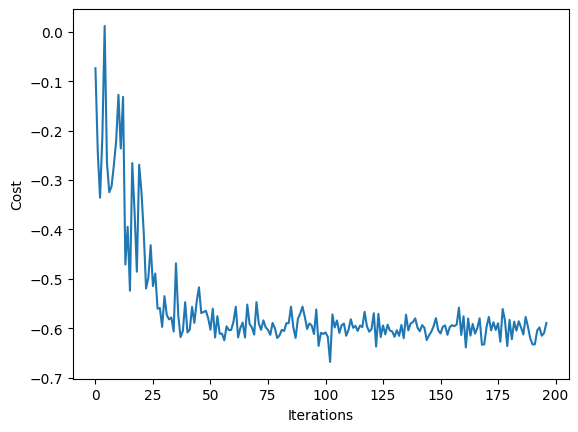

In [16]:
fig, ax = plt.subplots()
ax.plot(range(history["iters"]), history["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

## Step 5: VQE model scan

We'll now scan perform a parameter scan for the Schwinger model. Below we are just scanning over mass. However, you can modify the code to scan over any other parameters in the model; for example, the coupling strength or lattice spacing.

In [17]:
coupling = 1
num_sites = 8
spacing = 2
left_gauge = 0.5
mass_min = -2.0
mass_max = 2.0    
mass_step = 0.5
mass_range = np.arange(mass_min, mass_max + mass_step, mass_step)

vqe_params = []

for mass in tqdm(mass_range):
    model = LatticeSchwingerModel(mass, coupling, num_sites, spacing, left_gauge)

    hamiltonian = model.get_hamiltonian()
    num_qubits = hamiltonian[0].num_qubits
    hamiltonian_matrix = sum(op.to_matrix() for op in hamiltonian)

    eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian_matrix)
    
    optimize_result = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator, history, False),
        method="cobyla",
    )

    vqe_params.append(optimize_result.x)

100%|██████████| 9/9 [02:26<00:00, 16.25s/it]


We now have a list of arrays of ansatz parameters that can be used to prepare the ground state for each point in our parameter scan. This will be used as our dataset to train and test the quantum convolutional neural network in the next notebook, which has been prepared by my esteemed IBM colleague, Kate Marshall.

## References

1. A variational eigenvalue solver on a quantum processor, A. Peruzzo et al., 2013.
   <https://arxiv.org/abs/1304.3061>
2. Quantum data learning for quantum simulations in high-energy physics, L. Nagano et al., 2023.
   <https://arxiv.org/abs/2306.17214>

## Version check

In [18]:
from qiskit import version as qiskit_version

qiskit_version.get_version_info()

'1.2.0'

In [19]:
from qiskit_aer import version as qiskit_aer_version

qiskit_aer_version.get_version_info()

'0.15.0'